In [47]:
# Import the data and label coordinates



# Create label maps from the coordinates



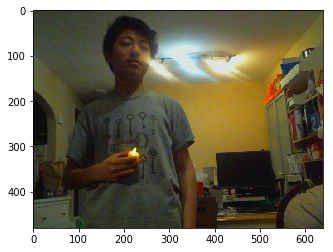

In [48]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms

loader = transforms.Compose([
  #transforms.Resize(img_size),
  #transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 

def load_image(filename, volatile=False):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    return image_tensor
    #image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    #return image_var.cuda

plt.imshow(load_image('data/fk_cndls/left/32.jpg').numpy().transpose(1,2,0))

In [67]:
import torch
import torch.nn.functional as F
from torch import nn
CPU_DEBUG = False

# Setup the model
%env CUDA_LAUNCH_BLOCKING=1
device = torch.device("cpu" if CPU_DEBUG else "cuda")

class CoarseFireDetector(nn.Module):
    # Your code goes here
    def __init__(self):
        super(CoarseFireDetector, self).__init__()
        self.layers = nn.ModuleList([nn.Conv2d(3, 32, 5, bias=True)])
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(32, 32, 5, stride=1, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(32, 32, 5, stride=1, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(32, 16, 3, stride=1, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(16, 1, 3, stride=1, bias=True))
        #self.layers.append(nn.Sigmoid())
    
    def forward(self, input):
        out = input 
        print(input.dim())
        if input.dim() == 3:
            out = out.unsqueeze(0)
            for layer in self.layers:
                out = layer(out)
            return out.squeeze()
        else:
            for layer in self.layers:
                out = layer(out)
            return out 
    

env: CUDA_LAUNCH_BLOCKING=1


3
torch.Size([230, 310])


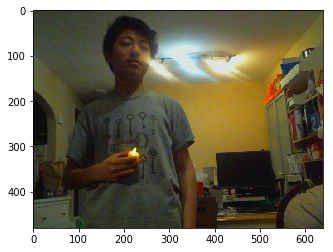

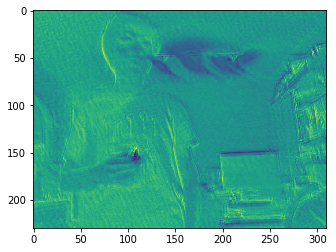

(230, 310)


In [68]:
cf_detector = CoarseFireDetector().cuda()
out = cf_detector(load_image('data/fk_cndls/left/32.jpg').cuda())
print(out.size())
plt.imshow(load_image('data/fk_cndls/left/32.jpg').numpy().transpose(1,2,0))
plt.show()
plt.imshow(out.cpu().detach().numpy())
plt.show()
print(out.cpu().detach().numpy().shape)
label_shape = out.cpu().detach().numpy().shape

In [69]:
import os
import pickle
import pprint

def show_torch_img(tensor):
    plt.imshow(tensor.detach().cpu().numpy().transpose(1,2,0))
    plt.show()

pp = pprint.PrettyPrinter(indent=2)

# Training Dataset
data = "data/fk_cndls"
metadp = "metadata.dat"
metadata = None
with open(os.path.join(data, metadp), 'rb') as metadf:
    metadata = pickle.load(metadf)
    pp.pprint(metadata)
    metadata = dict((k,metadata[k]) for k in range(0, 34))

# load the input imgs
input_imgs = []
coords = []
for i, num in enumerate(metadata):
    input_imgs.append(load_image(metadata[num]['left']['img_path']))
    coords.append(metadata[num]['left']['coords'])
    input_imgs.append(load_image(metadata[num]['right']['img_path']))
    coords.append(metadata[num]['right']['coords'])
    #print(coords[-2])
    #show_torch_img(input_imgs[-2])
    #show_torch_img(input_imgs[-1])

{ 0: { 'left': { 'coords': {0: (140, 129)},
                 'img_path': './data/fk_cndls/left/0.jpg'},
       'right': { 'coords': {0: (495, 147)},
                  'img_path': './data/fk_cndls/right/0.jpg'}},
  1: { 'left': { 'coords': {0: (173, 251)},
                 'img_path': './data/fk_cndls/left/1.jpg'},
       'right': { 'coords': {0: (407, 266)},
                  'img_path': './data/fk_cndls/right/1.jpg'}},
  2: { 'left': { 'coords': {0: (85, 125)},
                 'img_path': './data/fk_cndls/left/2.jpg'},
       'right': { 'coords': {0: (370, 142)},
                  'img_path': './data/fk_cndls/right/2.jpg'}},
  3: { 'left': { 'coords': {0: (160, 336)},
                 'img_path': './data/fk_cndls/left/3.jpg'},
       'right': { 'coords': {0: (270, 351)},
                  'img_path': './data/fk_cndls/right/3.jpg'}},
  4: { 'left': { 'coords': {0: (233, 391)},
                 'img_path': './data/fk_cndls/left/4.jpg'},
       'right': { 'coords': {0: (376, 404)},
    

2D Gaussian-like array:
[[0.06217652 0.08609905 0.11416176 0.14494171 0.17620431 0.20511153
  0.22861991 0.24399921 0.24935221 0.24399921 0.22861991 0.20511153
  0.17620431 0.14494171 0.11416176 0.08609905 0.06217652]
 [0.08609905 0.1192258  0.15808569 0.20070828 0.24399921 0.28402854
  0.3165818  0.33787832 0.34529089 0.33787832 0.3165818  0.28402854
  0.24399921 0.20070828 0.15808569 0.1192258  0.08609905]
 [0.11416176 0.15808569 0.20961139 0.26612618 0.32352716 0.37660345
  0.41976697 0.44800477 0.45783336 0.44800477 0.41976697 0.37660345
  0.32352716 0.26612618 0.20961139 0.15808569 0.11416176]
 [0.14494171 0.20070828 0.26612618 0.33787832 0.41075558 0.47814214
  0.53294328 0.56879448 0.58127302 0.56879448 0.53294328 0.47814214
  0.41075558 0.33787832 0.26612618 0.20070828 0.14494171]
 [0.17620431 0.24399921 0.32352716 0.41075558 0.49935179 0.58127302
  0.64789426 0.69147823 0.70664828 0.69147823 0.64789426 0.58127302
  0.49935179 0.41075558 0.32352716 0.24399921 0.17620431]
 [0.20

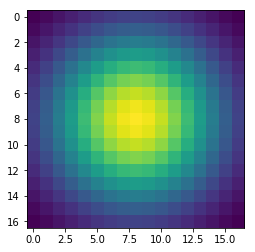

In [70]:
import numpy as np
w = 17
x, y = np.meshgrid(np.linspace(-1,1,w), np.linspace(-1,1,w))
d = np.sqrt(x*x+y*y)
sigma, mu = 0.6, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
print("2D Gaussian-like array:")
print(g)
plt.imshow(g)
print(g.shape)

labels = []
for num, img in enumerate(input_imgs):
    #print(num)
    # Create labels
    #print(metadata[num])
    #print(input_imgs[num])
    label = np.zeros(label_shape)
    #print(coords[num])
    coord = coords[num][0]
    _, input_imgs_w, input_imgs_h = input_imgs[num].numpy().shape
    #print(input_imgs_w, input_imgs_h)
    #print(label_shape)
    #print(coord)
    central = (int(coord[0]/input_imgs_w*label_shape[0]), 
                    int(coord[1]/input_imgs_h*label_shape[1]))
    #print(central)
    #print(central)
    side = w // 2 
    for i in range(-side, side+1):
        for j in range(-side, side+1):
            lx = min(max(central[1]+i, 0),label_shape[0]-1)
            ly = min(max(central[0]+j, 0),label_shape[1]-1)
            label[lx, ly] += g[i+side, j+side] 
    #show_torch_img(img)
    #plt.show()
    #plt.imshow(label)
    #plt.show()
    #show_torch_img
    labels.append(label)
 

In [82]:
from torch import FloatTensor
from torch import optim
import random

cf_detector = CoarseFireDetector().cuda()

optimizer = optim.Adam(cf_detector.parameters(), lr = 0.001) 

n_epochs = 3
batch_size = 4
for i in range(n_epochs):
    batch_img = []
    batch_label = []
    batch_weight = []
    
    combined = list(zip(input_imgs, labels))
    random.shuffle(combined)
    input_imgs[:], labels[:] = zip(*combined)
    
    for j, (img, label) in enumerate(zip(input_imgs, labels)):
        batch_img.append(img.cuda()/255-0.5)
        batch_label.append(FloatTensor(label).cuda())
        weights = np.zeros_like(label)
        weights[label<0.0001] = 1.0
        weights[label>=0.0001] = 6.0
        batch_weight.append(FloatTensor(weights).cuda())
        if len(batch_img) >= batch_size:
            bimgs = torch.stack(batch_img)
            bweights = torch.stack(batch_weight)
            blabels = torch.stack(batch_label)
            optimizer.zero_grad()
            out = cf_detector(bimgs).squeeze()
            print(out.size())
            print(bweights.size())
            #loss = torch.mean(bweights*(blabels-out)**2)
            loss = torch.mean(bweights*(blabels-out)**2)
            #loss = torch.sum((FloatTensor(label).cuda()-out)**2)
            loss.backward()
            optimizer.step()
            batch_img = []
            batch_label = []
            batch_weight = []
            print(loss.item())
    
    

4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.009240505285561085
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.006008775904774666
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.009211011230945587
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.008583568036556244
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.005978739354759455
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.0065113636665046215
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.0068146116100251675
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.006846104748547077
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.006699722725898027
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.006459362339228392
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.006189962849020958
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.005962117575109005
4
torch.Size([4, 230, 310])
torch.Size([4, 230, 310])
0.005843947175890207
4
torch.Size([4, 230, 3

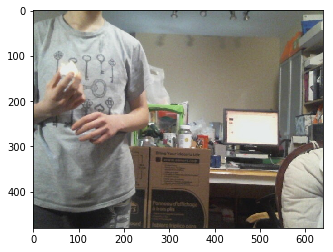

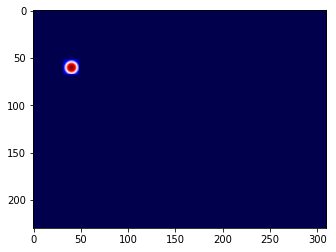

3


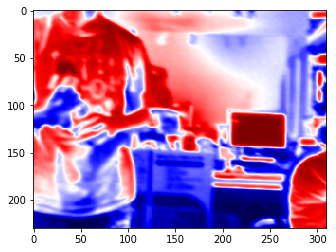

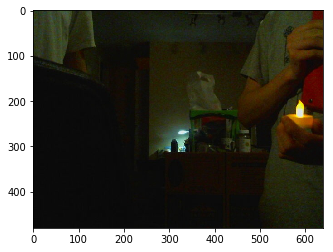

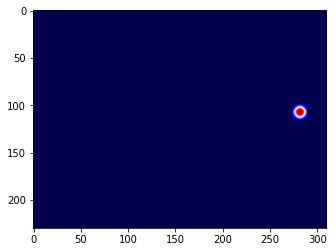

3


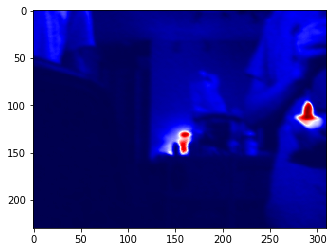

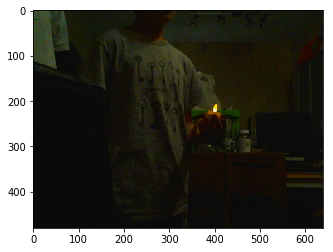

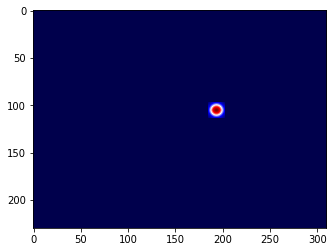

3


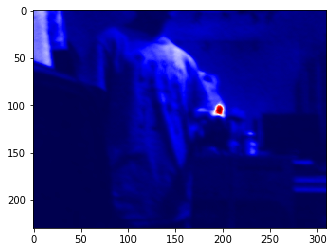

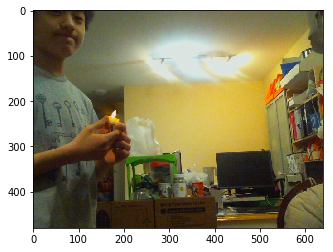

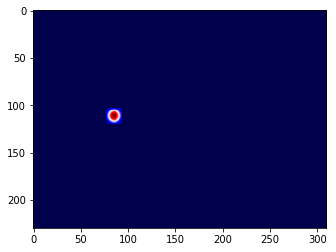

3


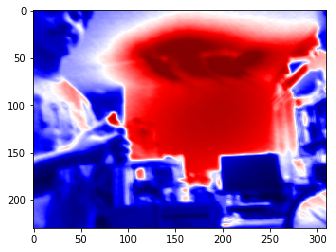

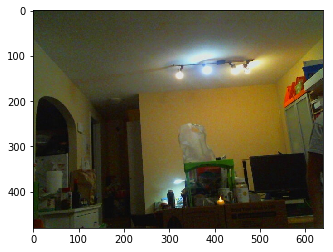

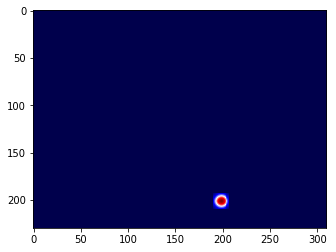

3


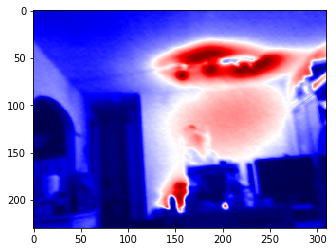

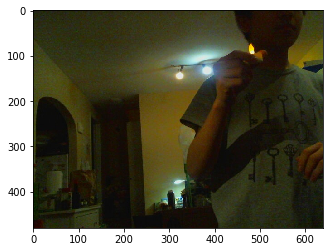

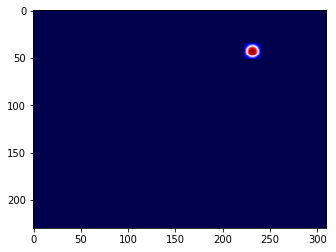

3


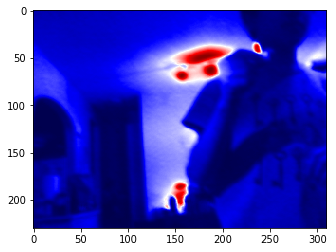

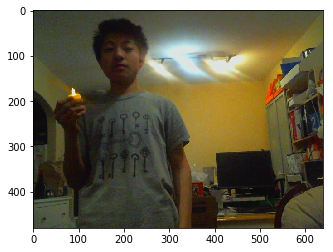

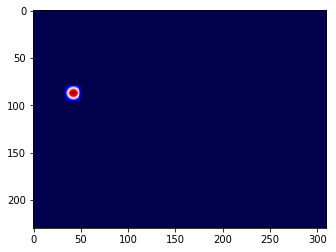

3


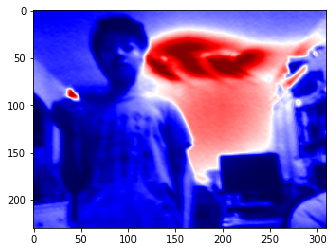

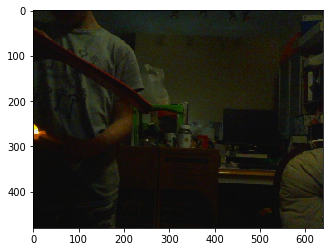

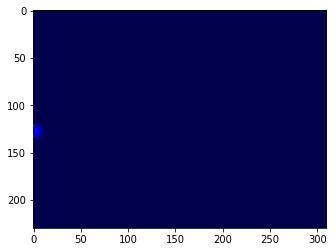

3


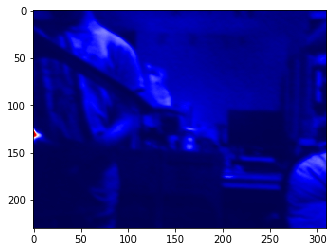

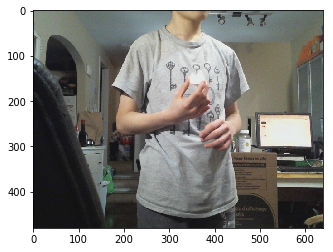

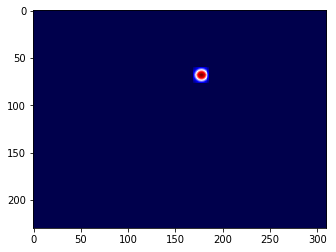

3


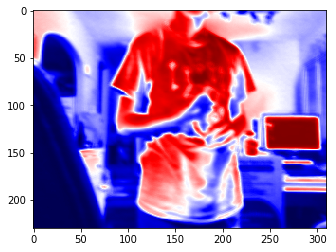

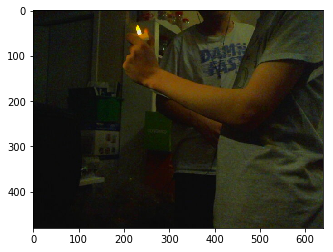

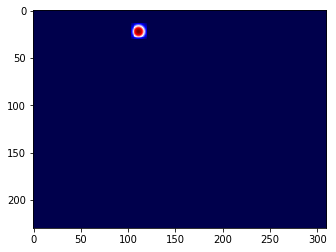

3


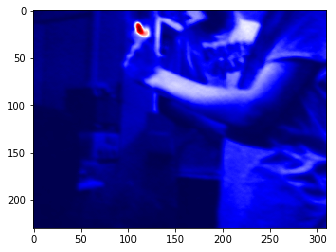

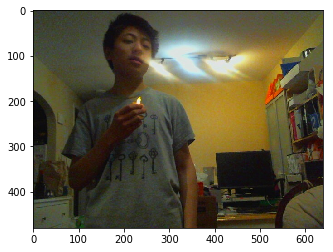

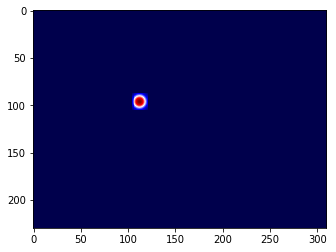

3


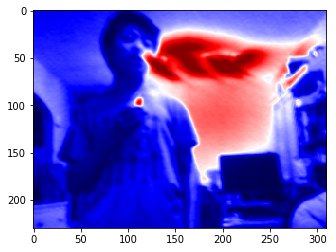

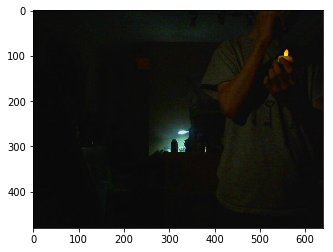

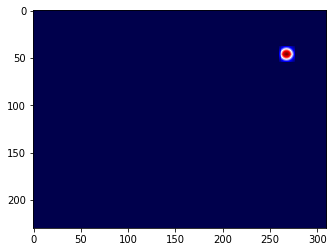

3


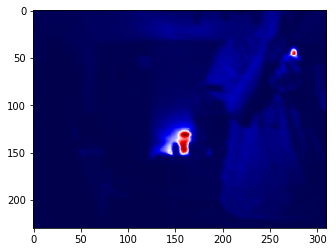

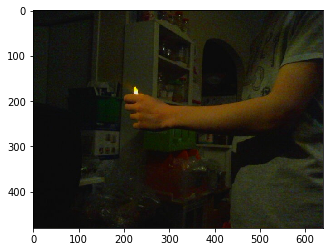

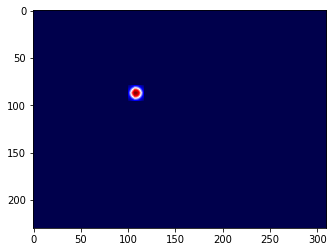

3


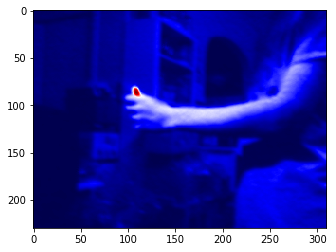

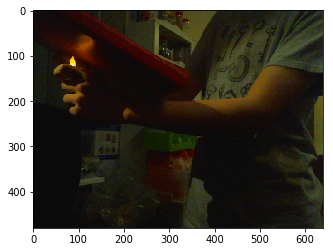

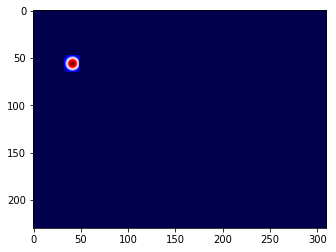

3


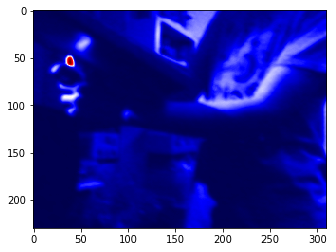

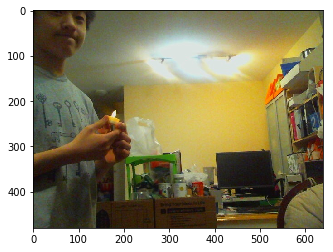

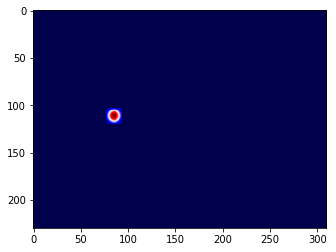

3


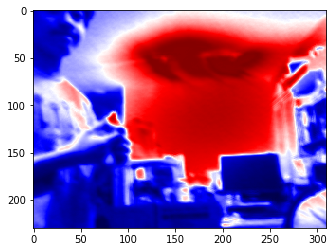

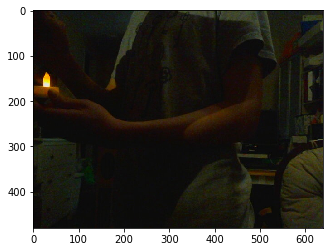

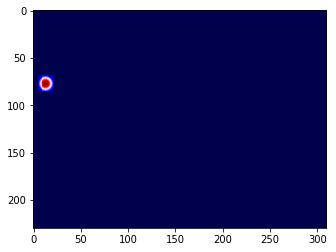

3


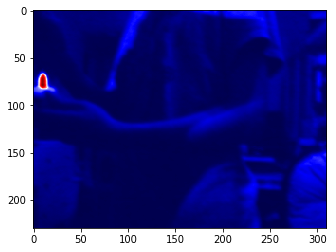

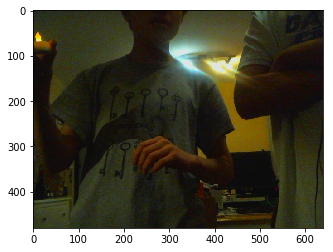

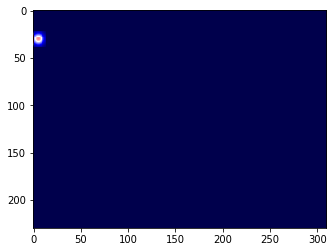

3


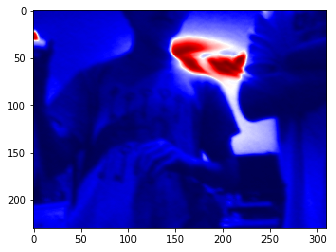

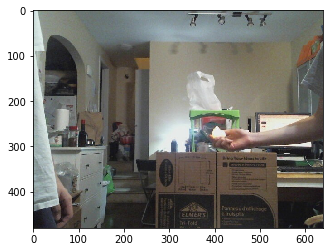

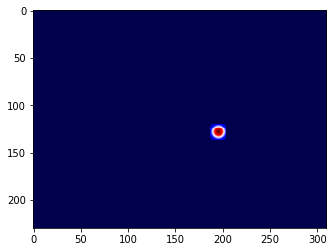

3


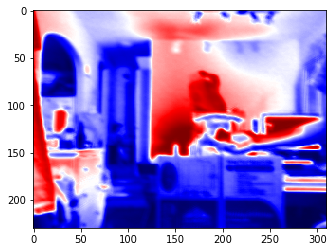

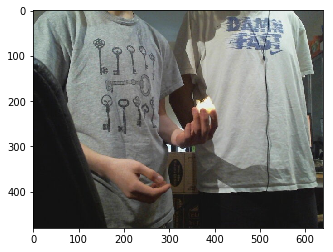

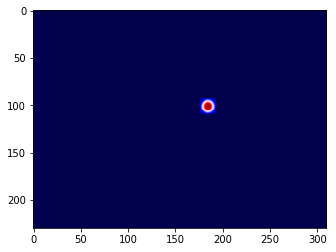

3


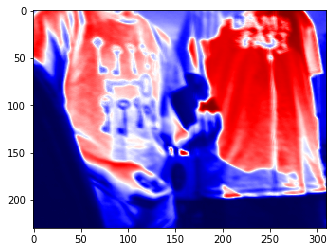

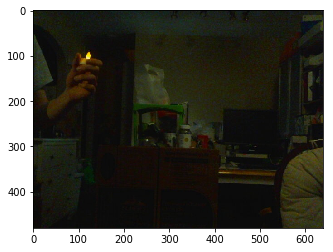

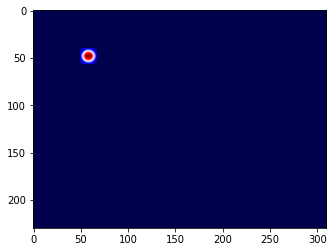

3


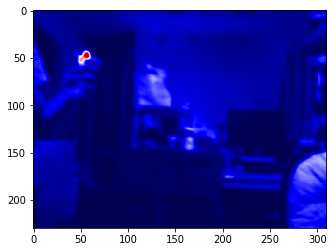

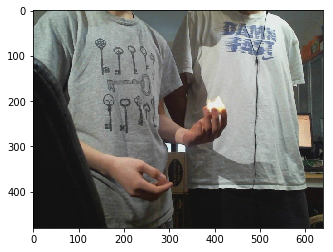

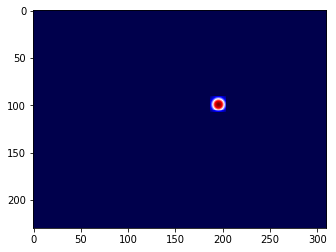

3


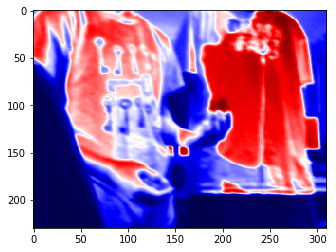

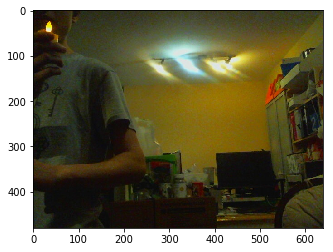

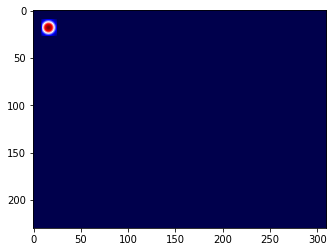

3


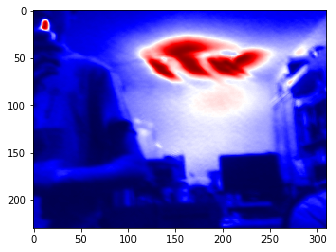

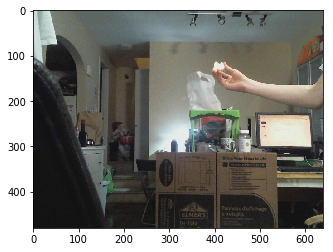

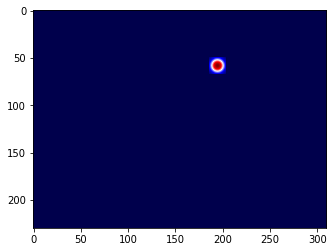

3


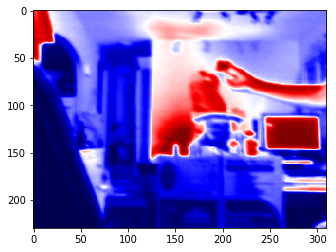

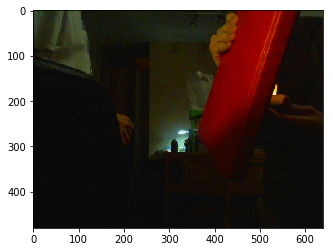

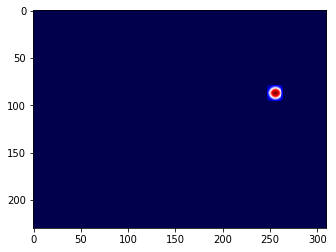

3


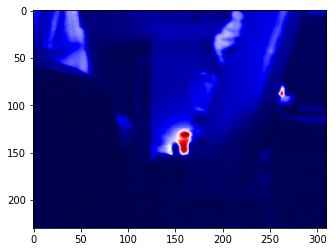

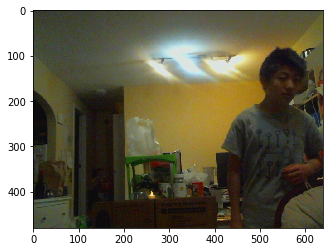

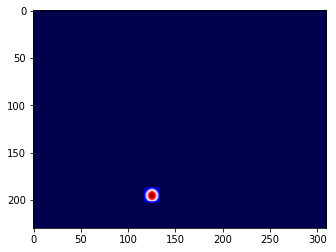

3


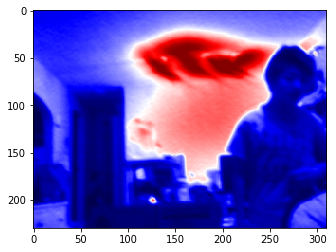

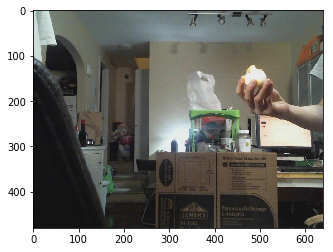

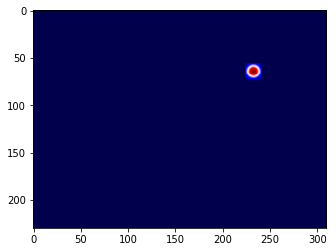

3


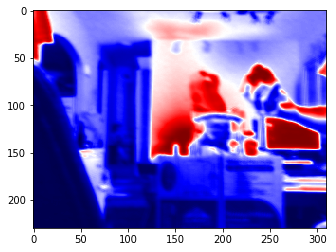

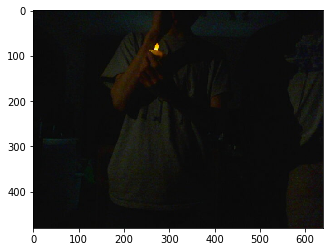

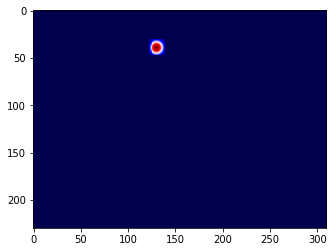

3


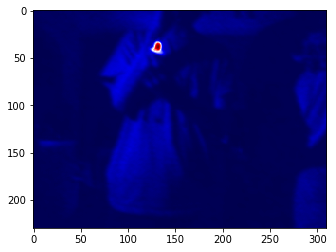

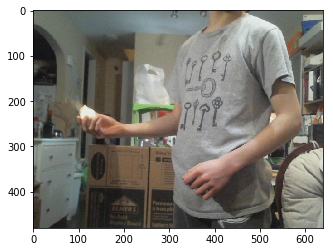

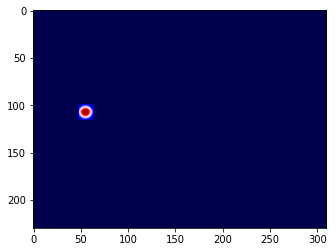

3


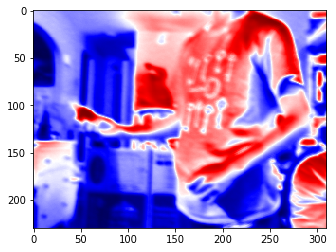

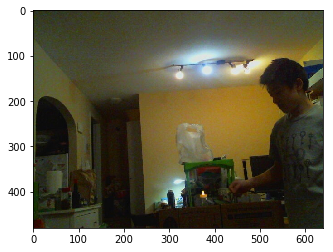

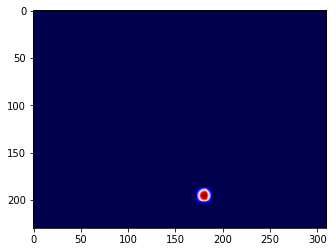

3


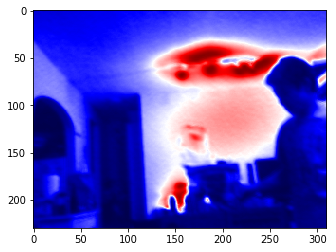

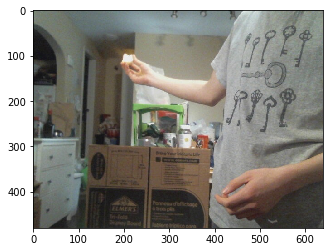

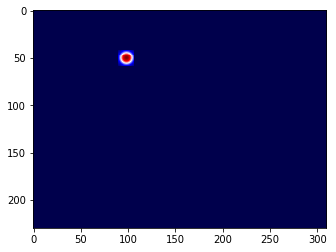

3


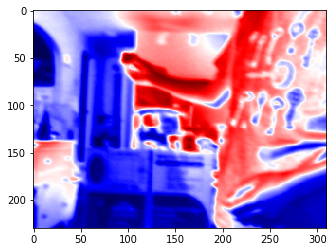

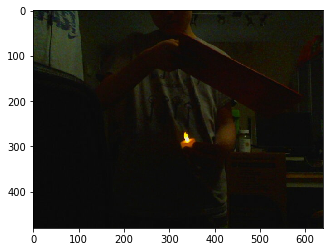

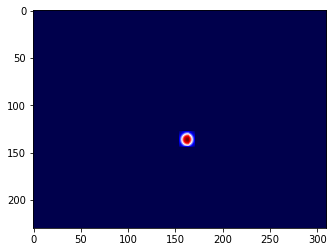

3


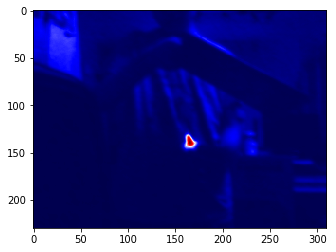

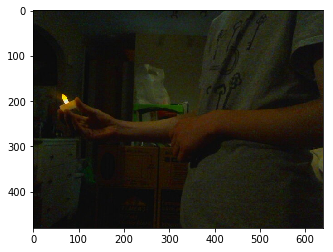

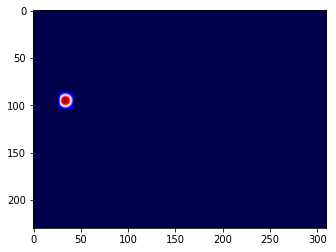

3


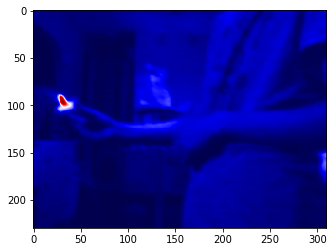

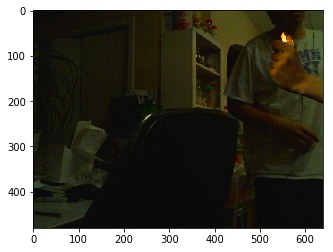

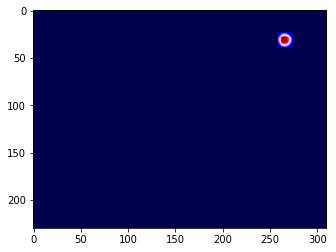

3


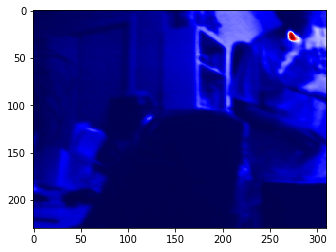

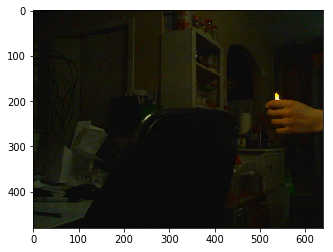

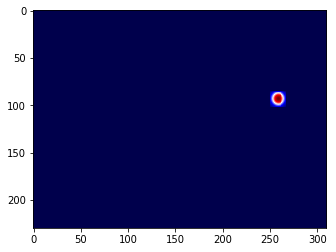

3


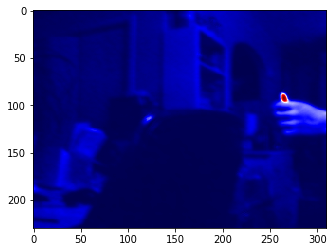

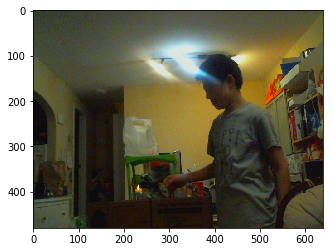

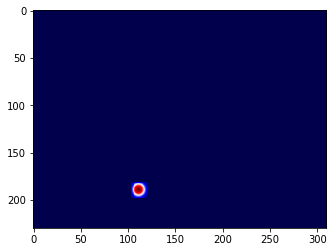

3


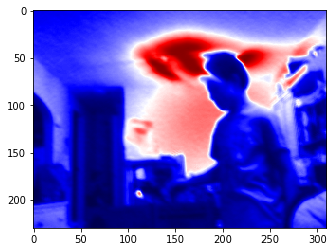

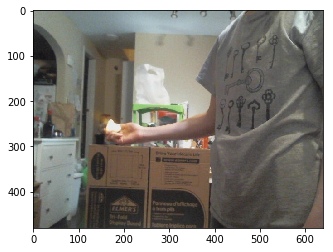

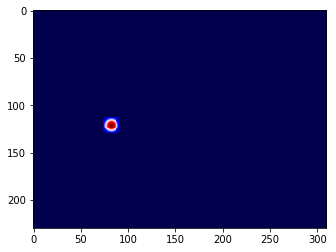

3


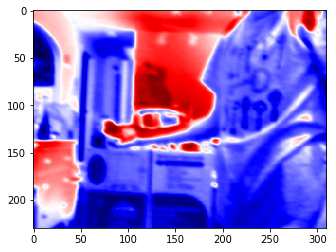

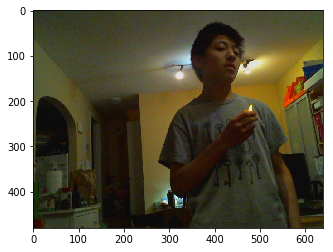

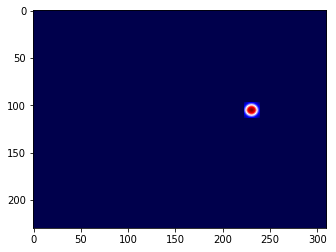

3


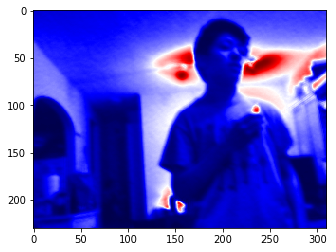

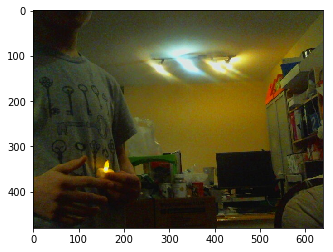

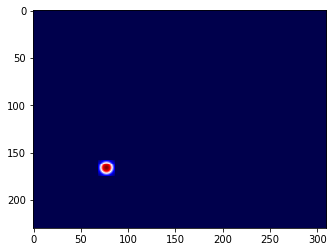

3


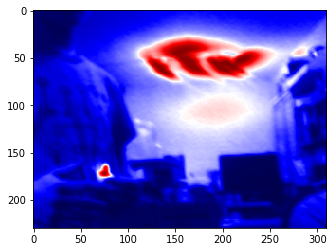

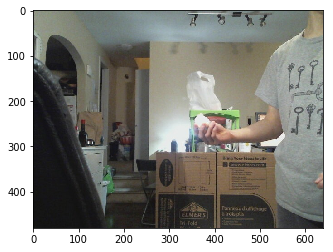

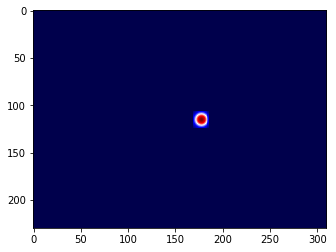

3


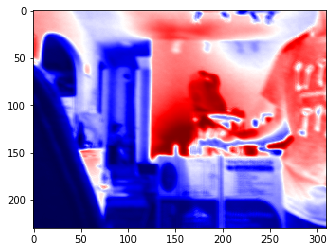

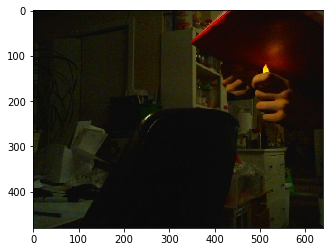

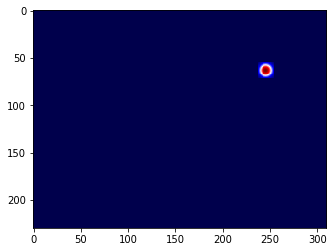

3


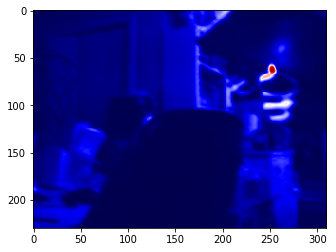

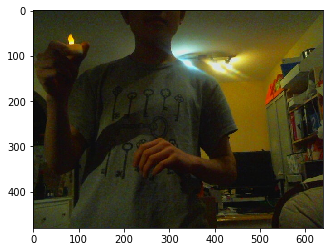

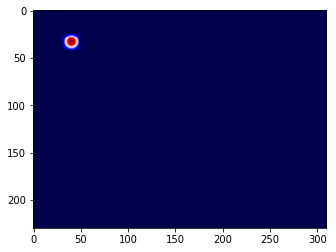

3


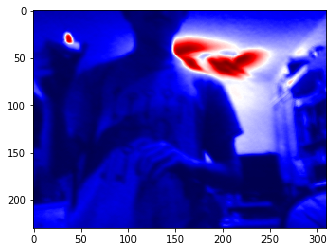

In [83]:
for j, (img, label) in enumerate(zip(input_imgs, labels)):
    if j>40:
        break
    show_torch_img(img)
    plt.imshow(label, cmap = "seismic")
    plt.show()
    plt.imshow(cf_detector.cuda()(img.cuda()/255-0.5).cpu().detach().numpy(), cmap = "seismic")
    plt.show()